In [56]:
import Project_library as pl
import jax
import jax.numpy as jnp

import cvxpy as cp

In [57]:
min_observation = jnp.deg2rad(30)
# Calculate the visible area, given the minimum observational angle

# Only works when at equator
def visible_angle(min_observation, satellite_position : jnp.ndarray) -> tuple[float, float, float, float, float, float]:
    """Calculate the visible angle area of a satellite given its position.

    Args:
        min_observation (float): The minimum observational angle in radians.
        satellite_position (jnp.ndarray): The position of the satellite in Cartesian coordinates.

    Returns:
        tuple: A tuple containing the visible area and the radius of the visible area.
    """
    # Calculate the distance from the satellite to the center of the Earth
    distance = jnp.linalg.norm(satellite_position)
    # Calculate the radius of the Earth
    earth_radius = 6371  # in km

    #
    bing = jnp.sin(min_observation+jnp.pi/2)

    print(bing)

    # Calculate the angle of the satellite
    alpha = jnp.arcsin(earth_radius*bing/distance)
    # Calculate the angle from the center of the earth
    lat_width = jnp.pi/2 - alpha - min_observation

    # Calculate the spherical value of the satellite
    radius, longitude, latitude = pl.cartesian_to_spherical(*satellite_position)
    
    # Define the ranges of the visible area
    lat_range = (latitude.item() - lat_width, latitude.item() + lat_width)
    lon_range = (longitude.item() - lat_width, longitude.item() + lat_width)

    print(longitude, latitude, lat_range, lon_range)


    return lat_range, lon_range, radius, alpha, distance, lat_width

In [58]:
radius_earth = 6371 # in km
satellite_altitude = 600 # in km

# Set satellite above the equator
satellite_position = jnp.array([radius_earth + satellite_altitude, 0, 0]) # in km


# Calculate the visible area
lat_range, lon_range, radius, alpha, distance, lat_width = visible_angle(min_observation, satellite_position)

# Generate the grid of points to evaluate the visible area, given a grid size of 50 km
grid_size = 50 # in km

angle_of_cell_size = grid_size/radius_earth
print(angle_of_cell_size)

# Calculate the number of cells in the grid
num_cells_lat = int((lat_range[1] - lat_range[0]) / angle_of_cell_size)
num_cells_lon = int((lon_range[1] - lon_range[0]) / angle_of_cell_size)

# Generate the grid of points
mesh_grid = jnp.stack(pl.generate_latitude_longitude_points(num_cells_lat, num_cells_lon,lat_range, lon_range), axis=-1)

# Print the mesh grid

0.8660254
0.0 0.0 (Array(-0.13396132, dtype=float32), Array(0.13396132, dtype=float32)) (Array(-0.13396132, dtype=float32), Array(0.13396132, dtype=float32))
0.007848061528802385


In [59]:
# Create a random distribution of demand of the grid points, as the points represent an agregate user.
r = 0.5
demand = jax.random.uniform(jax.random.PRNGKey(0), shape=(num_cells_lat, num_cells_lon), minval=r*200e3, maxval=r*750e3)

users = []

# Create a user with the demand on the set point in the grid
for i in range(num_cells_lat):
    mini_user = []
    for j in range(num_cells_lon):
        if demand[i,j] > 0:
            # Create a user with the demand on the set point in the grid
            mini_user.append(pl.User(mesh_grid[i,j][0]
                                    ,mesh_grid[i,j][1],
                                     i*num_cells_lat+j
                                     ,demand[i,j],
                                      position=pl.spherical_to_cartesian(radius_earth, mesh_grid[i,j][0], mesh_grid[i,j][1])))
            
    users.append(mini_user)


In [60]:
print(users[0][0].position)

(Array(6263.9004, dtype=float32), Array(-819.0611, dtype=float32), Array(-826.03357, dtype=float32))


In [61]:
# Calculate the distance between users and the satellite
d = []
for i in range(num_cells_lat):
    dm  = []
    for j in range(num_cells_lon):
        if demand[i,j] > 0:
            # Calculate the distance between the user and the satellite
            dm.append(jnp.linalg.norm(jnp.asarray(users[i][j].position )- satellite_position))
    d.append(dm)

d = jnp.array(d).flatten()

           

In [ ]:
# Satellite def
Satellite_power_per_beam = 75 # in W
Satellite_beams = 40 # Number of beams
Satellite_bandwidth = 30e6 # in Hz
Sky_temperature = 290 # in K
Satellite_gain = 30 # in dB
Satellite_central_frequency = 2 # in GHz

snr = jax.vmap(pl.calculate_snr, in_axes=(None,None,None,0,None))(Satellite_power_per_beam, Satellite_gain, Satellite_bandwidth, d, 0)

# Calculate the rate
Rates = jax.vmap(pl.calculate_capacity, in_axes=(0,None))(snr, Satellite_bandwidth)

Rates

Array([3871235. , 4053856.8, 4241521.5, ..., 4241521.5, 4053856.8,
       3871235. ], dtype=float32)

In [63]:
# Flatten the users
#users = [user for sublist in users for user in sublist]
i = 1
users[i//num_cells_lon][i%num_cells_lon].demand

Array(369109.47, dtype=float32)

In [64]:


# Setup the optimization problem

# Define the variables
time_slot = 1 # in seconds
time_window = 10 # in seconds


x = cp.Variable((time_window, len(d)), boolean=True) # Binary variable for the user assignment

constraints = []

# Constraints for the user assignment
# (C1) Each user can be assigned to only one satellite beam
for i in range(len(d)):
    constraints.append(cp.sum(x[:,i]) <= 1)

# (C2) The demand of the users must be satisfied
for i in range(len(d)):
    constraints.append(cp.sum(x[:,i] * Rates[i] * time_slot) >= users[i//num_cells_lon][i%num_cells_lon].demand)

# (C3) The value can only be binary
constraints.append(x >= 0)
constraints.append(x <= 1)


objective = cp.Minimize(0) # Dummy objective function, as we are only interested in the feasibility


problem = cp.Problem(objective, constraints)
problem.solve()

if x.value is not None:
    schedule = jnp.round(x.value).astype(int)
    print("Schedule:")
    print(schedule)
else:
    print("No feasible solution found.")

Schedule:
[[1 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


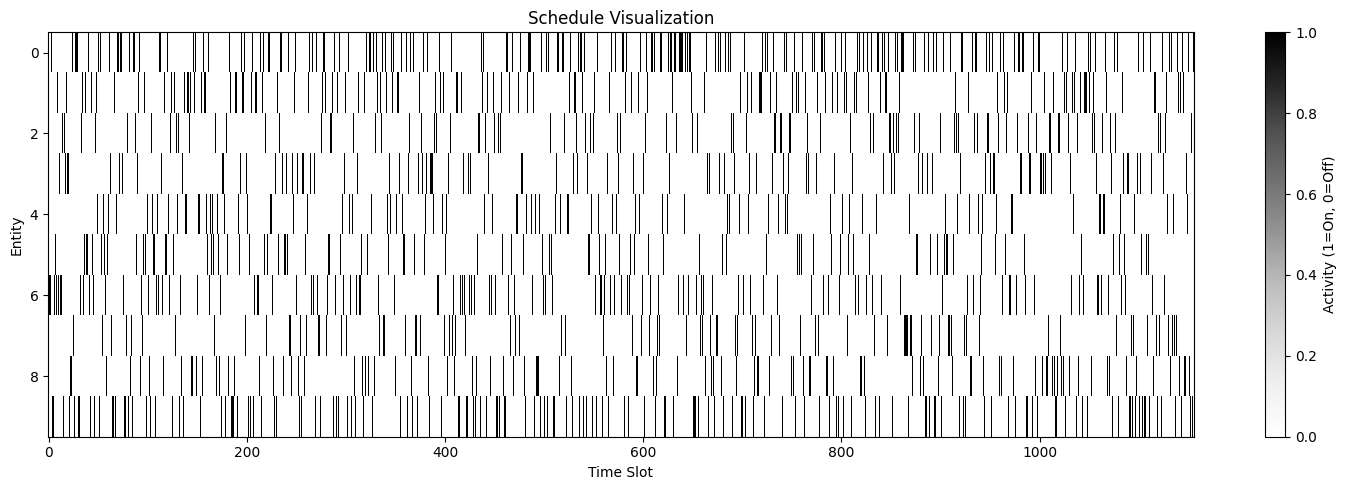

In [65]:
import matplotlib.pyplot as plt

jnp.round(x.value).astype(int).shape



plt.figure(figsize=(15, 5))
plt.imshow(schedule, aspect='auto', cmap='Greys', interpolation='nearest')
plt.colorbar(label='Activity (1=On, 0=Off)')
plt.xlabel('Time Slot')
plt.ylabel('Entity')
plt.title('Schedule Visualization')
plt.tight_layout()
plt.show()

In [ ]:
# Less strict optimisation
